In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\12779\.conda\envs\paint\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pre and post processing for images
img_size = 512
prep = transforms.Compose([transforms.Resize([img_size, img_size]),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
prep_render =  transforms.Compose([transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [3]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['mosaic.jpg', 'bingbing.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
# opt_img = Variable(content_image.data.clone(), requires_grad=True)

print(content_image.shape)

torch.Size([1, 3, 512, 512])


In [4]:
from render import Render, Strokes
from pseudo_render.pseudo_render import Render as PseudoRender
import pickle

s = pickle.load(open("strokes.pkl", "rb"))
render = Render(s)
pseudo_render = PseudoRender(s)
strokes = Strokes(s)

initialize network with normal
loading renderer from pre-trained checkpoint...
torch.Size([1, 1, 1, 8, 8])
torch.Size([1, 1, 1, 8, 12])
torch.Size([1, 2, 2, 8, 8])
torch.Size([1, 2, 2, 8, 12])
torch.Size([1, 4, 4, 8, 8])
torch.Size([1, 4, 4, 8, 12])
torch.Size([1, 8, 8, 8, 8])
torch.Size([1, 8, 8, 8, 12])
torch.Size([1, 16, 16, 8, 8])
torch.Size([1, 16, 16, 8, 12])
torch.Size([1, 17, 17, 8, 8])
torch.Size([1, 17, 17, 8, 12])


c:\Users\12779\.conda\envs\paint\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([3, 512, 512])


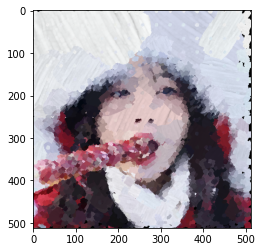

In [5]:
print(render(strokes()).shape)
out_img = postp(prep_render(render(strokes()).cpu().squeeze()))
imshow(out_img)

torch.Size([3, 512, 512])


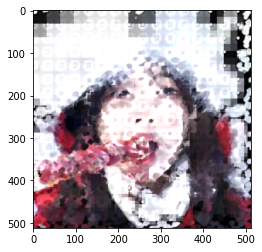

In [6]:
print(pseudo_render(strokes()).shape)
out_img = postp(prep_render(pseudo_render(strokes()).cpu().squeeze()))
imshow(out_img)

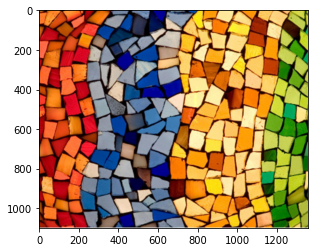

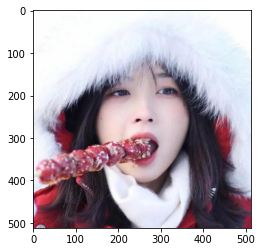

In [7]:
#display images
for img in imgs:
    imshow(img);show()

Iteration: 5, loss: 25130758144.000000
Iteration: 10, loss: 19375333376.000000
Iteration: 15, loss: 16060977152.000000
Iteration: 20, loss: 13771612160.000000
Iteration: 25, loss: 11899855872.000000
Iteration: 30, loss: 10581231616.000000
Iteration: 35, loss: 9433946112.000000
Iteration: 40, loss: 8405009920.000000
Iteration: 45, loss: 7488077312.000000
Iteration: 50, loss: 6652800000.000000
Iteration: 55, loss: 5893364224.000000
Iteration: 60, loss: 5216662528.000000
Iteration: 65, loss: 4616238080.000000
Iteration: 70, loss: 4108735488.000000
Iteration: 75, loss: 3667916544.000000
Iteration: 80, loss: 3266616064.000000
Iteration: 85, loss: 2916665344.000000
Iteration: 90, loss: 2617241344.000000
Iteration: 95, loss: 2357254400.000000
Iteration: 100, loss: 2124846464.000000
Iteration: 105, loss: 1920035968.000000
Iteration: 110, loss: 1741966464.000000
Iteration: 115, loss: 1582209152.000000
Iteration: 120, loss: 1441110016.000000
Iteration: 125, loss: 1317309696.000000
Iteration: 130

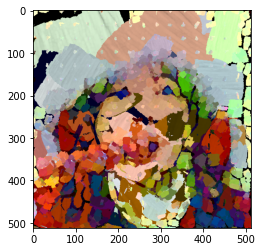

In [8]:
#run style transfer
max_iter = 200
show_iter = 5
optimizer = optim.Adam(strokes.parameters(), 0.002)
n_iter=[0]

from loss import VGGStyleLoss, PixelLoss
style = VGGStyleLoss(transfer_mode=1)
l1 = PixelLoss()

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        pseudo_render_result = prep_render(pseudo_render(strokes())).unsqueeze(0)
        # render_result = prep_render(render(strokes())).unsqueeze(0)
        loss = l1(pseudo_render_result, content_image) * 1
        # loss += l1(render_result, content_image) * 1
        if n_iter[0] > 0:
            loss += style(pseudo_render_result, style_image) * 0.5
            for params in optimizer.param_groups:                      
                params['lr'] *= 1
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(prep_render(render(strokes())).cpu())
imshow(out_img)

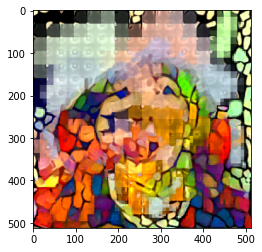

In [9]:
out_img = postp(prep_render(pseudo_render(strokes())).cpu())
imshow(out_img)